In [1]:
import pandas as pd

In [2]:
# path to fasta file with restriction enzyme recognition sequence:
fasta_file_re = "lab_enzymes.fa"
# path to genome file
genome = "../genome.fa"

!seqkit locate --bed -f $fasta_file_re $genome -j 34 -F > lab_enzymes.bed
!awk -F "\t" '{print $1 "\t" $2 "\t" $4}' lab_enzymes.bed > lab_enzymes_3c.bed

In [3]:
enzyme_list = pd.read_csv("lab_enzymes_3c.bed", sep="\t", names=['Chr', 'cutsite', 'name'])
enzyme_list

,Chr,cutsite,name
0,I,25449,SalI-HF
1,I,36015,SalI-HF
2,I,39963,SalI-HF
3,I,48310,SalI-HF
4,I,55239,SalI-HF
...,...,...,...
2624180,MtDNA,3125,MboI
2624181,MtDNA,1321,MboI
2624182,MtDNA,1105,MboI
2624183,MtDNA,926,MboI


In [4]:
chromosomes = enzyme_list['Chr'].unique()
print(chromosomes)
enzymes = enzyme_list['name'].unique()
print(enzymes)

Chrom_sizes = {
    'I' : 15072434,
    'II' : 15279421,
    'III' : 13783801,
    'IV' : 17493829,
    'V' : 20924180,
    'X' : 17718942,
    'MtDNA' : 13794
}
print(Chrom_sizes)

['I' 'II' 'III' 'IV' 'V' 'X' 'MtDNA']
['SalI-HF' 'PvuII' 'SacI-HF' 'SacII' 'ApaI' 'PmlI' 'SapI' 'BglII'
 'EcoRV-HF' 'KpnI-HF' 'PstI-HF' 'ApaLI' 'XhoI' 'AflII' 'BsmAI' 'NcoI'
 'EcoRI-HF' 'BamHI-HF' 'HindIII-HF' 'DraI' 'HpaII' 'DpnI' 'NdeI' 'NheI'
 'EagI-HF' 'XbaI' 'NaeI' 'MboI']
{'I': 15072434, 'II': 15279421, 'III': 13783801, 'IV': 17493829, 'V': 20924180, 'X': 17718942, 'MtDNA': 13794}


In [5]:
enzyme_list.query('Chr == "I"')

,Chr,cutsite,name
0,I,25449,SalI-HF
1,I,36015,SalI-HF
2,I,39963,SalI-HF
3,I,48310,SalI-HF
4,I,55239,SalI-HF
...,...,...,...
414036,I,3974,DpnI
414037,I,3749,DpnI
414038,I,3680,DpnI
414039,I,2674,DpnI


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

print(enzymes)
def digest(zyme1, zyme2, cutoff):
    all_chr_fragment_lengths = []
    for chr in chromosomes:
        enzyme_1_df = enzyme_list.query('Chr == @chr & name == @zyme1')
        enzyme_2_df = enzyme_list.query('Chr == @chr & name == @zyme2')
        # Querying the chromosomes and enzymes provided and return a new dataframe
        list_of_enzyme_1_cutsites = enzyme_1_df['cutsite'].to_list()
        list_of_enzyme_2_cutsites = enzyme_2_df['cutsite'].to_list()
        # Making lists for the two enzyme cutting sites
        all_cutsites_list = list_of_enzyme_1_cutsites + list_of_enzyme_2_cutsites
        all_cutsites_list.append(1)
        all_cutsites_list.append(Chrom_sizes[chr])
        # Merging the two lists into one and add "1" and "chromosome length" to the list
        set_of_all_cutsites = set(all_cutsites_list)
        all_cutsites_list = list(set_of_all_cutsites)
        # Render the cut sites unique before sorting
        all_cutsites_list.sort()

        fragment_length = []
        last_position = 0
        for i in all_cutsites_list:
            if(last_position == 0):
                last_position = i
            else:
                fragment_length.append(i - last_position)
                last_position = i
        for item in fragment_length:
            all_chr_fragment_lengths.append(item)
        # Making the difference between the adjacent two items in the list 
    
    above_cutoff = []
    for fragment in all_chr_fragment_lengths:
        if fragment >= cutoff:
            above_cutoff.append(fragment)
    total_basepair = 0
    for i in above_cutoff:
        total_basepair += i
    ratio = 5000000/(5000000 + total_basepair)
    
    plt.hist(all_chr_fragment_lengths, bins=1000)
    plt.yscale('log')
    #plt.xscale("log")
    q95 = np.quantile(all_chr_fragment_lengths, q=0.95)
    plt.xlabel("Fragment length" + " [Array/(gDna + array) ratio above " + str(cutoff) + " bp = " + str(int(ratio*100)) + "%] ")
    plt.ylabel("Log of fragment number")
    if zyme1 == zyme2:
        plt.title(str(zyme1 + " (95 quantile: " + str(round(q95)) + " bp)"))
        plt.savefig(zyme1 + " cutoff = " + str(cutoff))
    else:
        plt.title(str(zyme1 + ' & ' + zyme2 + " (95 quantile: " + str(round(q95)) + " bp)"))
        plt.savefig(zyme1 + " & " + zyme2 + " cutoff = " + str(cutoff))
    plt.show()

    return ratio

['SalI-HF' 'PvuII' 'SacI-HF' 'SacII' 'ApaI' 'PmlI' 'SapI' 'BglII'
 'EcoRV-HF' 'KpnI-HF' 'PstI-HF' 'ApaLI' 'XhoI' 'AflII' 'BsmAI' 'NcoI'
 'EcoRI-HF' 'BamHI-HF' 'HindIII-HF' 'DraI' 'HpaII' 'DpnI' 'NdeI' 'NheI'
 'EagI-HF' 'XbaI' 'NaeI' 'MboI']


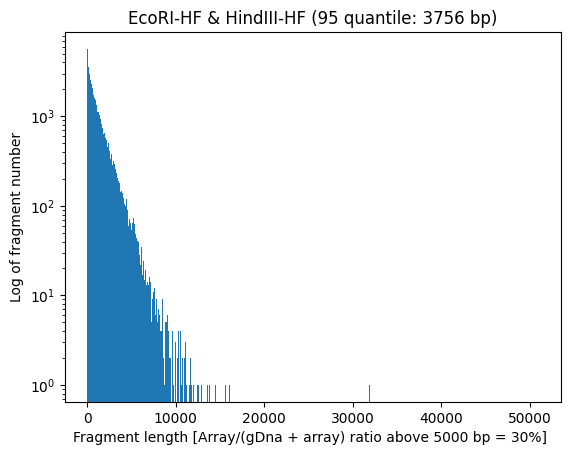

0.30745899834408735

In [7]:
digest("EcoRI-HF", "HindIII-HF", 5000)